# Tutorial 2: Image Classification with PyTLC

# Overview

* Introduce pre-trained models
* Build a superhero image classifier with pre-trained models in PyTLC
* Evaluate the classifier performance

# What is a Pre-Trained Model?

* A convolutional deep neural network (DNN) trained on a large dataset
* Example large dataset: image-net 14M images and 1000 classes
* Training DNNs on large dataset requires large GPU clusters running for days / weeks
* Useful as image featurizer for small dataset

<img src="files/pretrained_model_V2.png" width=500 height=500 />

# Pre-Trained DNN Models in PyTLC

PyTLC comes with the following pre-trained DNN models:

| DNN Model Name | Input Size | Output Size |
| --- | --- | --- |
| Resnet18 | 224 x 224 | 512 |
| Resnet50 | 224 x 224 | 2048 |
| Resnet101 | 224 x 224 | 2048 |
| Alexnet | 227 x 227 | 4096 |

* Pre-trained DNNs files are large and are not part of the PyTlc package wheel file
* PyTlc automatically downloads the DNNs on first use

# Scenario: Superman vs Spiderman Classification

<img src="files/vs.jpg" width=300 height=300 />

For this tutorial, we've picked superheroes because they're not in imagenet categories. Also, Superman and Spiderman both have red and blue costumes to make the detection harder.

Let's build a Superman vs Spiderman classifier in PyTlc, without much deep learning or image processing knowledge.

## Part 1: Exploratory Data Analysis

In [1]:
# General imports and helper functions
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from tutorial_helper import show_gallery, get_dimensions, label_counts, update_image_paths

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# Cell 1A
# Load data
data = pd.read_csv('files/data/data.csv')

# Exploratory analysis
print(data.head(), '\n')
print(label_counts(data), '\n')
print('Data shape: {}\n'.format(data.shape))

# Update image paths to use the faster disk
update_image_paths(data)

                      ImagePath  IsSuperman
0  files/data/spiderman_001.jpg           0
1  files/data/spiderman_002.jpg           0
2  files/data/spiderman_003.jpg           0
3  files/data/spiderman_004.jpg           0
4  files/data/spiderman_005.jpg           0 

Data label counts:
1    155
0    155
Name: IsSuperman, dtype: int64
 

Data shape: (310, 2)



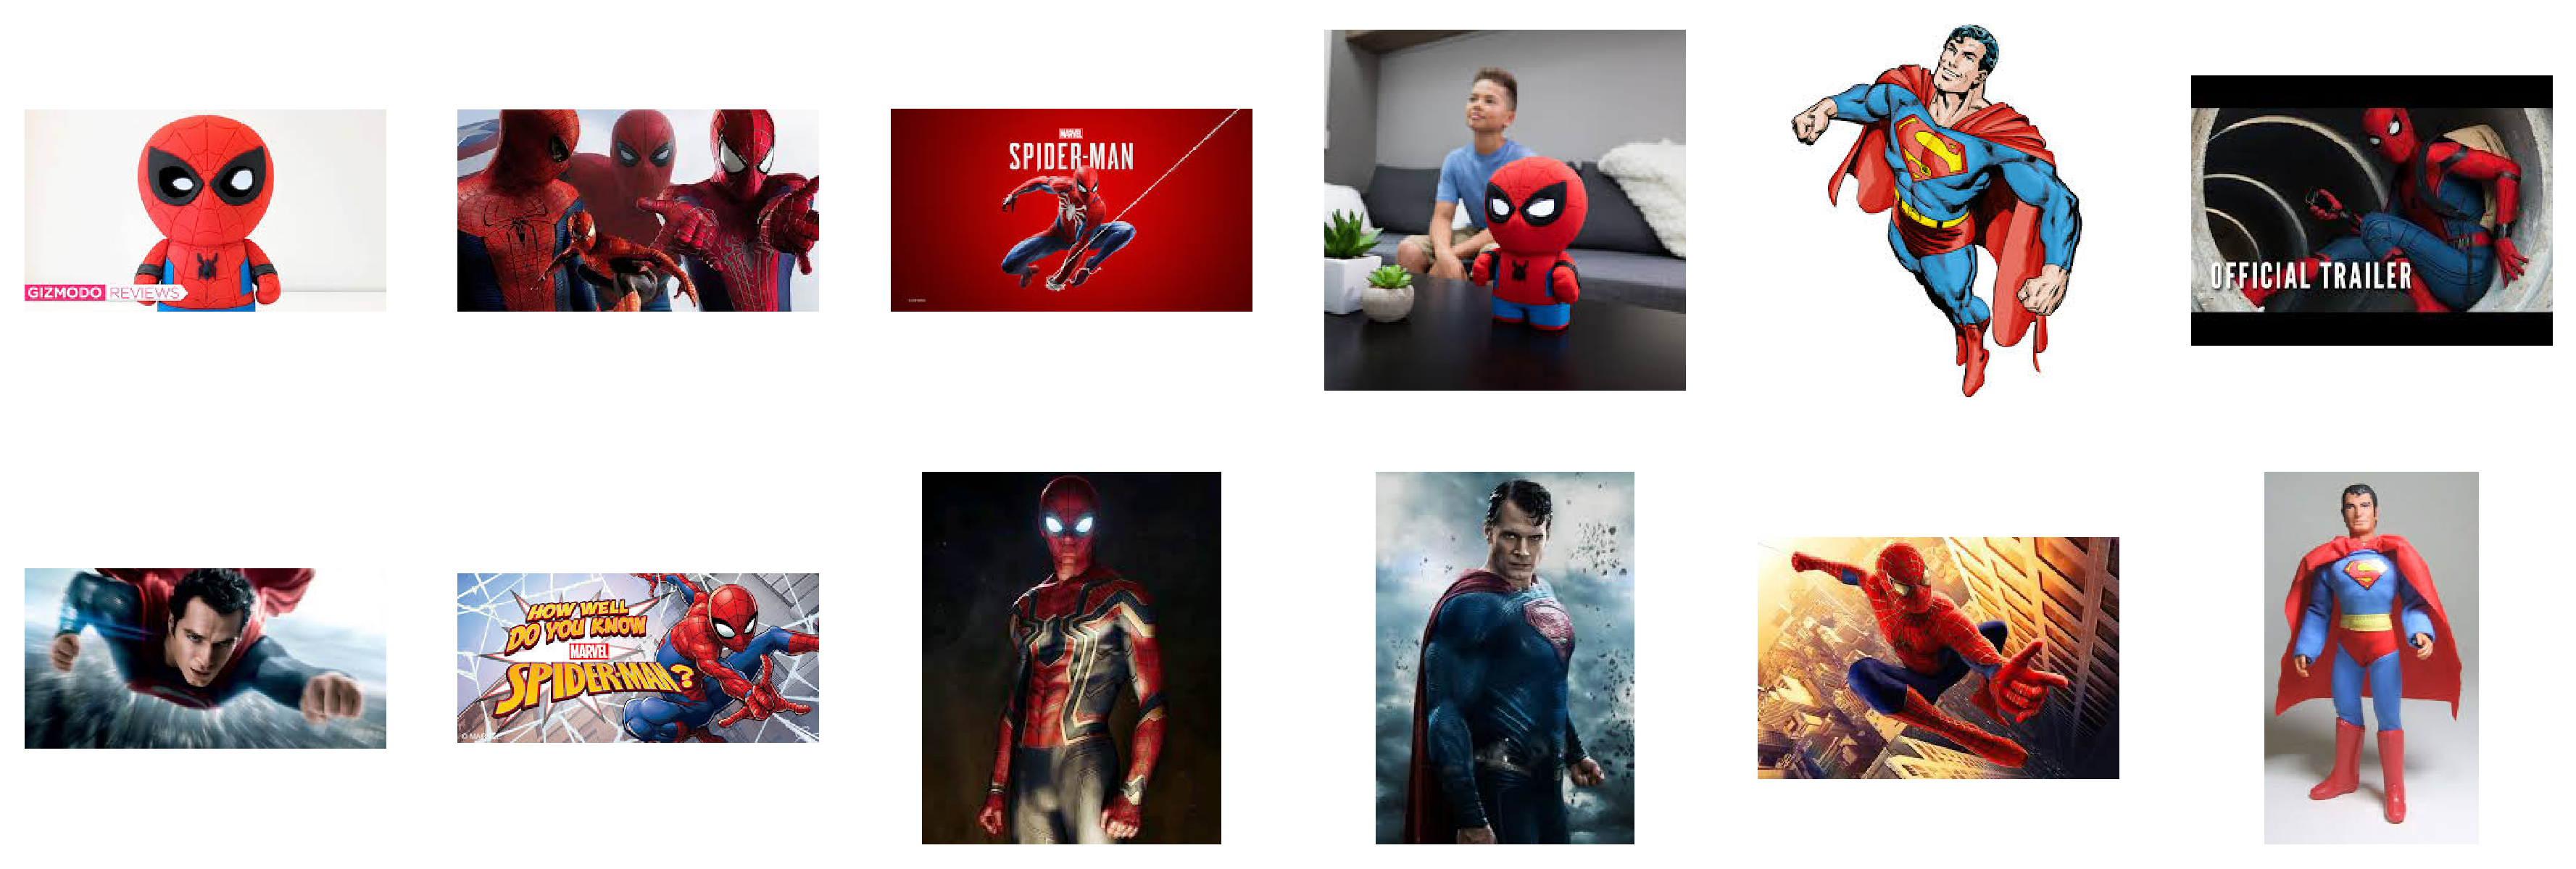

In [3]:
# Cell 1B
# Sample images
show_gallery(data)

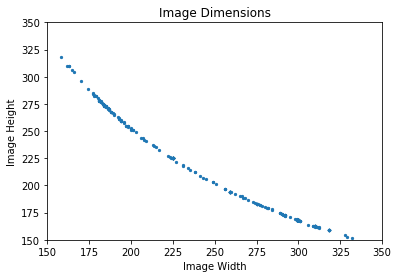

In [4]:
# Cell 1C
# Explore image dimensions
plt.scatter(*get_dimensions(data), s=5)
plt.xlim(150,350)
plt.ylim(150,350)
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Image Dimensions')
plt.show()

## Part 2: Feature Extraction with Pre-Trained Models
* Build feature extraction pipeline
* Extract and examine the output features

In [5]:
from microsoftml_scikit import Pipeline
from microsoftml_scikit.linear_model import LogisticRegressionBinaryClassifier
from microsoftml_scikit.feature_extraction.image import DnnFeaturizer, Loader, Resizer, PixelExtractor

In [36]:
# Cell 2A
# Create feature extraction pipeline
feature_extraction_pipeline = Pipeline([
    # Load image from path
    Loader() << {'Features':'ImagePath'},
    
    # Resize image to the correct inputs size of pretrained model
    Resizer(image_width=224, image_height=224, resizing='IsoPad'), # Replace xxx with the correct input size
    
    # Read pixel data as arrays
    PixelExtractor(),
    
    # Run the pretrained DNN model
    DnnFeaturizer(dnn_model='Resnet18')]) # Replace xxxx with one of these: Resenet18 Resnet50 Resnet101 Alexnet 

# Extract features
X_y = feature_extraction_pipeline.fit_transform(data.head(3))
X_y

,Features.0,Features.1,Features.10,Features.100,Features.1000,Features.10000,Features.100000,Features.100001,Features.100002,Features.100003,...,Features.99992,Features.99993,Features.99994,Features.99995,Features.99996,Features.99997,Features.99998,Features.99999,ImagePath,IsSuperman
0,0.0,0.0,0.0,5.0,5.0,181.0,131.0,133.0,133.0,129.0,...,156.0,176.0,171.0,163.0,145.0,125.0,127.0,135.0,/home/nbuser/local/Part3/files/data/spiderman_...,0
1,0.0,0.0,0.0,255.0,255.0,255.0,15.0,14.0,11.0,67.0,...,16.0,16.0,17.0,16.0,16.0,16.0,19.0,12.0,/home/nbuser/local/Part3/files/data/spiderman_...,0
2,31.0,32.0,35.0,35.0,34.0,194.0,74.0,74.0,75.0,76.0,...,191.0,86.0,77.0,79.0,79.0,77.0,80.0,78.0,/home/nbuser/local/Part3/files/data/spiderman_...,0


In [39]:
# Cell 2B
# Load pre-computed features
X_y = pd.read_csv('files/data/Resnet18.csv') # Replace mmmm with one of these: Resnet18 Resnet50 Resnet101 Alexnet
update_image_paths(X_y)
X_y.shape

(310, 514)

## Part 3: Build Classifier
* Split data into 80% training set and 20% test set
* Train a logistic regression classifier
* Evaluate the classifier with the test set

In [40]:
# Cell 3A
# Prepare train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(X_y,
                               train_size=0.8,
                               test_size=0.2, 
                               stratify=data.IsSuperman,
                               random_state=0) # Replace dddd with a random number
print(label_counts(train, 'Training'))
print(label_counts(test, 'Test'))

Training label counts:
1    124
0    124
Name: IsSuperman, dtype: int64

Test label counts:
1    31
0    31
Name: IsSuperman, dtype: int64



In [41]:
# Cell 3B
# Train a linear classifier
X_train = train.iloc[:,:-2]
y_train = train.IsSuperman

clf = Pipeline([LogisticRegressionBinaryClassifier()])
clf.fit(X_train, y_train)

In [42]:
# Cell 3B
# Test the classifier
X_test = test.iloc[:,:-2]
y_test = test.IsSuperman

predictions, metrics = clf.test(X_test, y_test)
metrics

,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
0,0.986472,0.951613,0.966667,0.935484,0.9375,0.967742,0.400977,59.902308,1,0.95082,0.985559


## Part 4: Evaluate Classifier Performance
* Look at the predictions
* Calculate confusion matrix
* Examine the classifier mistakes
* Calculate accuracy with 5-fold cross validation

In [12]:
# Cell 4A
# View Prediction
predictions.head()

,PredictedLabel,Probability,Score
0,1,0.874333,1.939829
1,0,0.166977,-1.607209
2,0,0.130238,-1.898853
3,0,0.439270,-0.244125
4,1,0.822079,1.530493


In [13]:
# Cell 4B
# Join predictions with paths and original label
path_and_label = test.reset_index()[['ImagePath', 'IsSuperman']].rename(columns={'IsSuperman': 'Label'})
predictions = pd.concat([path_and_label, predictions], axis=1)
predictions.head()

,ImagePath,Label,PredictedLabel,Probability,Score
0,/home/nbuser/local/Part3/files/data/superman_1...,1,1,0.874333,1.939829
1,/home/nbuser/local/Part3/files/data/spiderman_...,0,0,0.166977,-1.607209
2,/home/nbuser/local/Part3/files/data/spiderman_...,0,0,0.130238,-1.898853
3,/home/nbuser/local/Part3/files/data/superman_0...,1,0,0.439270,-0.244125
4,/home/nbuser/local/Part3/files/data/superman_1...,1,1,0.822079,1.530493


In [14]:
# Cell 4C
# View confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(predictions.Label, predictions.PredictedLabel)

array([[30,  1],
       [ 2, 29]])

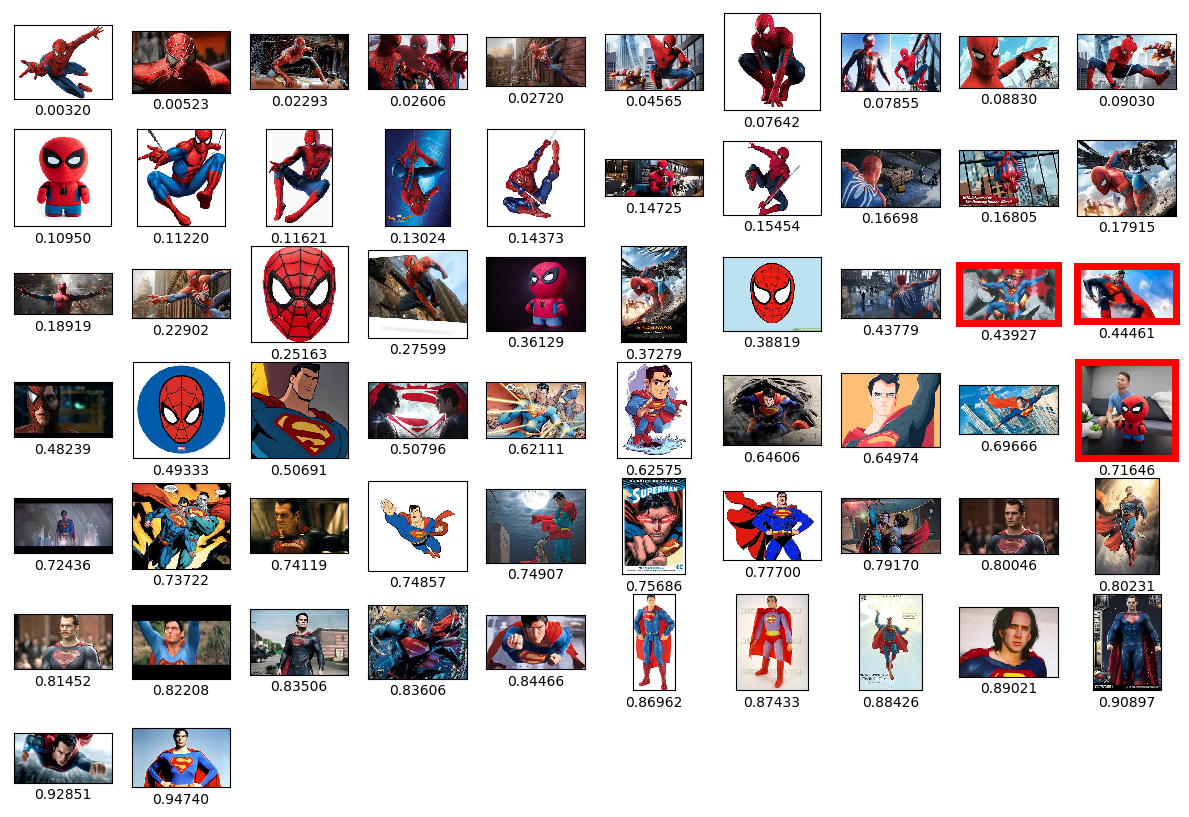

In [15]:
# Cell 4D
# Sort test images by predicted probability
predictions['IsMistake'] = predictions.Label != predictions.PredictedLabel
predictions.sort_values('Probability', inplace=True)
show_gallery(predictions, num_images=100, randomize=False, add_prob=True, flag_mistakes=True)

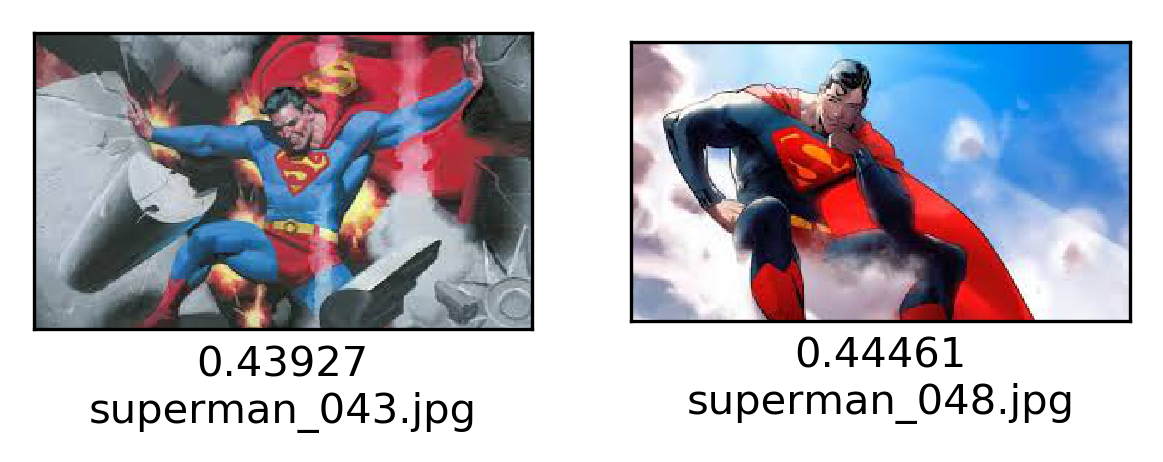

In [16]:
# Cell 4E
# View mistakes: Superman classified incorrectly
superman_mistakes = predictions[(predictions.Label == 1) & predictions.IsMistake] 
show_gallery(superman_mistakes, add_name=True, add_prob=True)

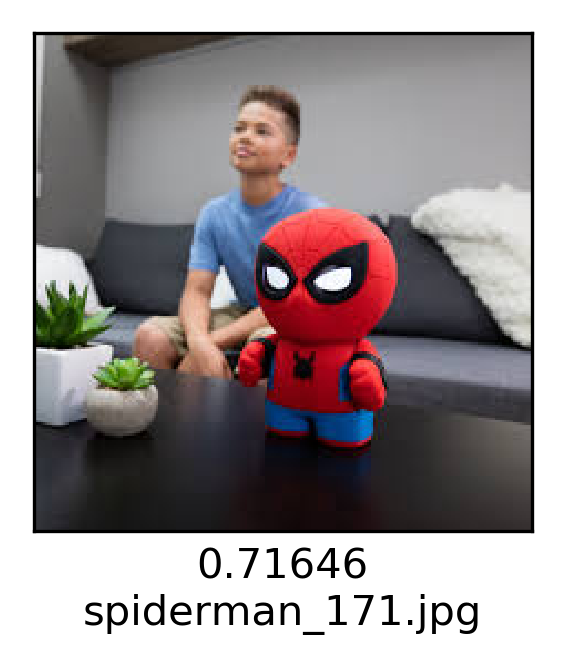

In [17]:
# Cell 4F
# View mistakes: Spiderman classified incorrectly
spiderman_mistakes = predictions[(predictions.Label == 0) & predictions.IsMistake] 
show_gallery(spiderman_mistakes, add_name=True, add_prob=True)

In [18]:
# Cell 4G
#Image('files/data/spiderman_111.jpg')

In [19]:
# Cell 4H
# Find accuracy with cross validation
from microsoftml_scikit.model_selection import CV
cross_validator = CV([LogisticRegressionBinaryClassifier()])
cv_results = cross_validator.fit(X_y.iloc[:,:-2], X_y.IsSuperman, cv=5)
list(cv_results.keys())

['models', 'predictions', 'metrics', 'metrics_summary', 'confusion_matrix']

In [20]:
# Cell 4I
# Metrics per fold
cv_results['metrics'].set_index('Fold')

,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
Fold,,,,,,,,,,,
0,0.996970,0.961538,0.966667,0.966667,0.954545,0.954545,0.263042,73.237089,0.982859,0.966667,0.997777
1,0.973789,0.916667,0.900000,0.923077,0.931818,0.911111,0.399152,59.937192,0.996317,0.911392,0.967583
2,0.994438,0.933333,0.903226,0.965517,0.965517,0.903226,0.347719,65.200220,0.999198,0.933333,0.994545
3,0.977391,0.916667,0.920000,0.920000,0.913043,0.913043,0.378426,62.109938,0.998747,0.920000,0.980726
4,0.993566,0.924242,0.885714,0.968750,0.967742,0.882353,0.332621,66.715883,0.999338,0.925373,0.993530


In [21]:
# Cell 4J
# Metrics summary statistics
cv_results['metrics_summary'][['AUC', 'Accuracy']]

,AUC,Accuracy
mean,0.987231,0.930490
std,0.010775,0.018663


# Recap
* Introduced what pre-trained DNNs are and how to use them in PyTLC
* Built a superman vs spiderman image classifier without any deep learning or image processing knowledge requirement
* The classifier achieves 93% accuracy with 5-fold cross validation